In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from scipy.optimize import curve_fit

In [4]:
datadir = 'C:/Users/khana/Documents/Masters/Semester 2/Earth and System Modelling/PLASIM/PLASIM Data/'
m100 = xr.open_dataset(datadir + 'm100_monthly.nc')
onepct = xr.open_dataset(datadir + 'onepct_monthly.nc')
double = xr.open_dataset(datadir + 'doubleCO2_monthly.nc')
preind = xr.open_dataset(datadir + 'preind_atm_monthly.nc')

In [5]:
#taking mean over latitude and longitude so we can plot time
GMST_m100 = m100.ts.mean('lat').mean('lon')
GMST_onepct = onepct.ts.mean('lat').mean('lon')
GMST_double = double.ts.mean('lat').mean('lon')

In [6]:
#creating a time array to help with plotting
time_m100 = np.arange(0,30,1)
time_onepct = np.arange(0,125,1)
time_double = np.arange(0,110,1)

In [7]:
#to store the new yearly mean surface temperature
GMST_m100_mm = np.zeros(len(time_m100))
GMST_onepct_mm = np.zeros(len(time_onepct))
GMST_double_mm = np.zeros(len(time_double))

#loop that calculates the yearly mean temp for each year in the given dataset
for i in range(len(time_m100)):
    GMST_m100_mm[i] = np.sum(GMST_m100[12*i:12*(i+1)])/12

for i in range(len(time_onepct)):
    GMST_onepct_mm[i] = np.sum(GMST_onepct[12*i:12*(i+1)])/12

for i in range(len(time_double)):
    GMST_double_mm[i] = np.sum(GMST_double[12*i:12*(i+1)])/12

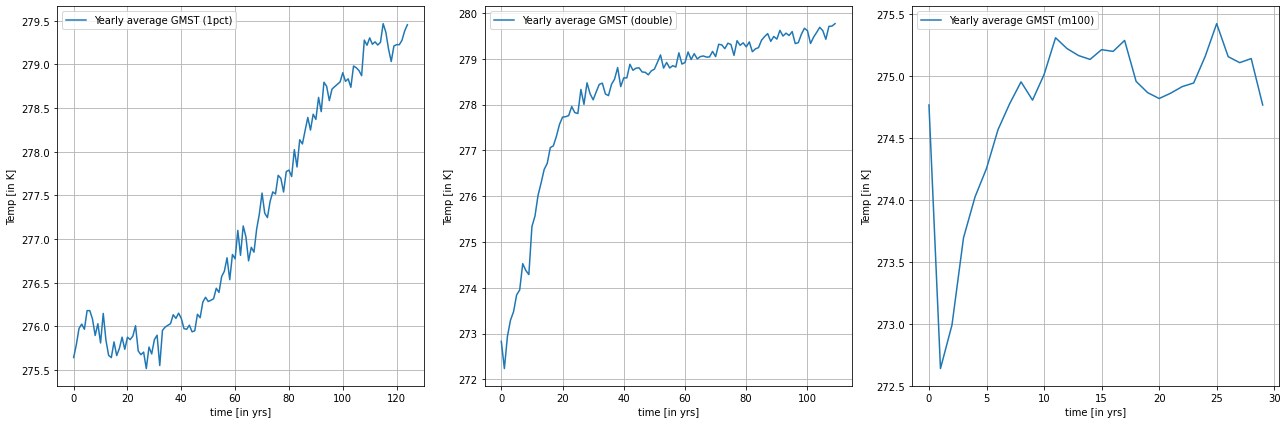

In [8]:
#plotting the yearly mean over time
fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp [in K]')
ax2.legend()
ax2.grid()

ax3.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp [in K]')
ax3.legend()
ax3.grid()

plt.tight_layout()

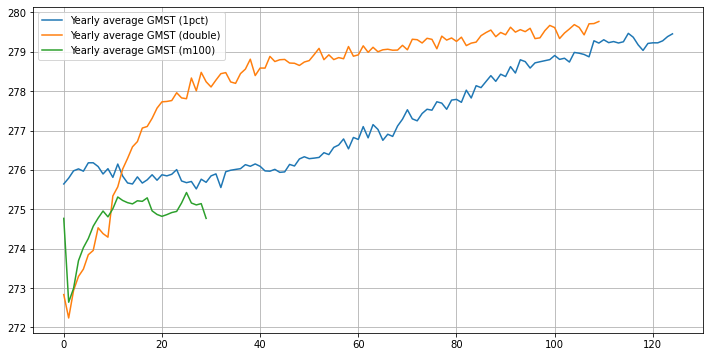

In [9]:
#all the plots together
plt.figure(figsize=(12,6))
plt.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
plt.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
plt.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
plt.legend()
plt.grid()
plt.show()


In [10]:
#define the carbon concentration (C(tau)) and their forcing F(tau)
def m100_carbon(tau):
    CO2 = [285 for i in range(len(time_m100))]
    CO2[1] = CO2[0] - 100
    return CO2[tau]

def m100_F(tau):
    return (3.74/np.log(2))*np.log(m100_carbon(tau)/m100_carbon(0))

In [11]:
#function that calculates the sum using the formula above
def m100_temp(t,q1,q2,d1,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*m100_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [12]:
#curve fit
m100_fit, _ = curve_fit(m100_temp,time_m100,GMST_m100_mm - GMST_m100_mm[0])
print('fit values for m100:',m100_fit)

fit values for m100: [0.65326283 0.35295434 2.25061545 2.25060583]


In [13]:
#the ECS seems to be close to what we want

m100_ECS = 3.74 * (m100_fit[0] + m100_fit[1])
m100_ECS

3.7632521860451895

In [14]:
#TCR is no-where near what we want, because the d1,d2 values are wrong

m100_TCR = 3.74 * (m100_fit[0]*(1-m100_fit[2]/70*(1-np.exp(-70/m100_fit[2]))) 
                   + m100_fit[1]* (1-m100_fit[3]/70*(1-np.exp(-70/m100_fit[3]))))
m100_TCR

3.6422576028814686

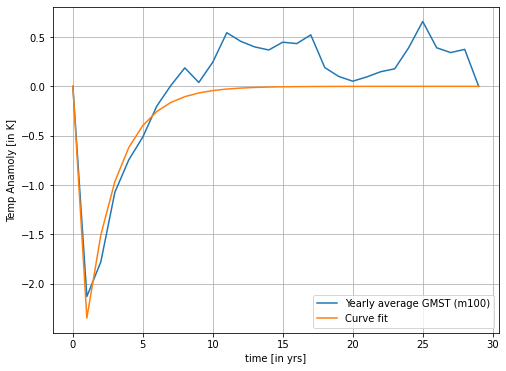

In [15]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='Yearly average GMST (m100)')
ax1.plot(time_m100, m100_temp(time_m100, *m100_fit), label='Curve fit')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

In [14]:
def onepct_carbon(tau):
    CO2 = [285 for i in range(len(time_onepct))]
    for i in range(len(time_onepct)-1):
        if (21<=i<=90):
            CO2[i + 1] = CO2[i] + 0.01 * CO2[i]
        if (91<=i):
            CO2[i] = 571.9
    return CO2[tau]

def onepct_F(tau):
    return (3.74/np.log(2))*np.log(onepct_carbon(tau)/onepct_carbon(0))

In [38]:
def onepct_temp(t,q1,q2,d1,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*onepct_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [39]:
onepct_fit, _ = curve_fit(onepct_temp, time_onepct, GMST_onepct_mm - GMST_onepct_mm[0])
print('fit values for onepct:',onepct_fit)

fit values for onepct: [-12.1146977   12.14980836  14.23110813  14.27528795]


In [40]:
onepct_ECS = 3.74 * (onepct_fit[0] + onepct_fit[1])
onepct_ECS

0.13131387081834406

In [41]:
onepct_TCR = 3.74 * (onepct_fit[0]*(1-onepct_fit[2]/70*(1-np.exp(-70/onepct_fit[2]))) 
                   + onepct_fit[1]* (1-onepct_fit[3]/70*(1-np.exp(-70/onepct_fit[3]))))
onepct_TCR

0.07738183528362964

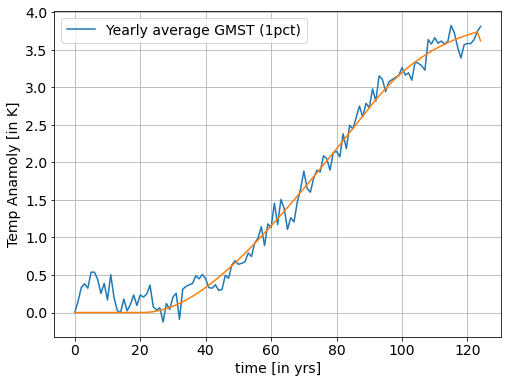

In [42]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, onepct_temp(time_onepct, *onepct_fit))
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()


In [16]:
def double_carbon(tau):
    CO2 = [285 for i in range(len(time_double))]
    CO2[1] = CO2[0] * 2
    return CO2[tau]

def double_F(tau):
    return (3.74/np.log(2))*np.log(double_carbon(tau)/double_carbon(0))

In [17]:
def double_temp(t,q1,q2,d1,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*double_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [18]:
#curve fit for the double forcing
double_fit, _ = curve_fit(double_temp, time_double, GMST_double_mm - GMST_double_mm[10])
print('fit values for double:',double_fit)

fit values for double: [-0.46470058 -0.46470061  3.28146988  3.28146976]


In [19]:
#its all over the place!

double_ECS = 3.74 * (double_fit[0]+double_fit[1])
double_ECS

-3.4759604374010955

In [20]:
#doesn't look nice

double_TCR = 3.74 * (double_fit[0]*(1-double_fit[2]/70*(1-np.exp(-70/double_fit[2]))) 
                   + double_fit[1]* (1-double_fit[3]/70*(1-np.exp(-70/double_fit[3]))))
double_TCR

-3.313013876483118

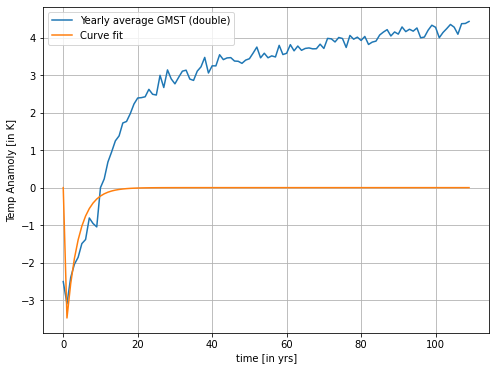

In [21]:
fig = plt.figure(figsize = (8,6))
ax2 = fig.add_subplot(1,1,1)

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[10], label='Yearly average GMST (double)')
ax2.plot(time_double, double_temp(time_double, *double_fit), label='Curve fit')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

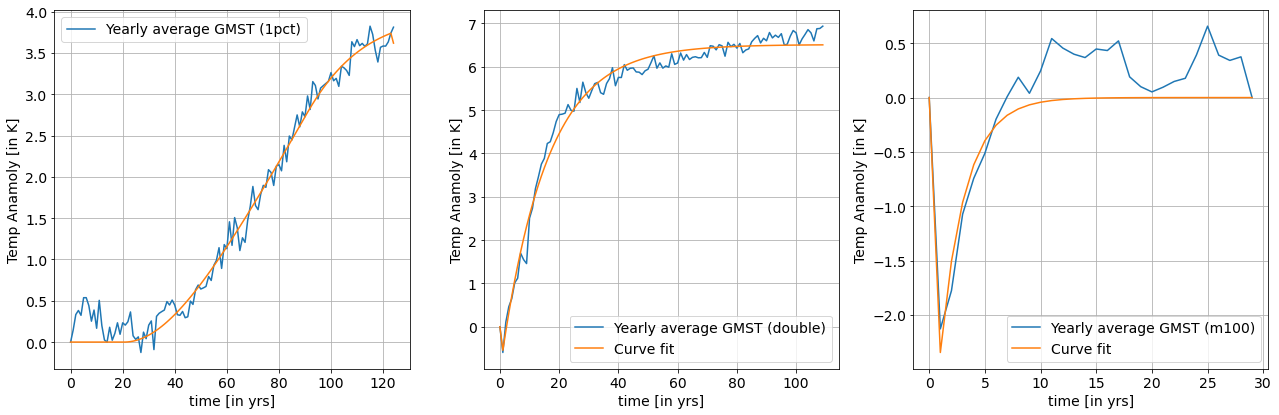

In [49]:
#everything together


fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, onepct_temp(time_onepct, *onepct_fit))
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='Yearly average GMST (double)')
ax2.plot(time_double, double_temp(time_double, *double_fit), label='Curve fit')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

ax3.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='Yearly average GMST (m100)')
ax3.plot(time_m100, m100_temp(time_m100, *m100_fit), label='Curve fit')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp Anamoly [in K]')
ax3.legend()
ax3.grid()

plt.tight_layout()

In [50]:
# define results as easy to use emulator
def F(tau,C):
    return (3.74/np.log(2))*np.log(C(tau)/C(0))

def temp(t,q1,q2,d1,d2,C):
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*F(j,C))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

def emulator_pulse(t,C):
    return temp(t,*m100_fit,C)

def emulator_onepct(t,C):
    return temp(t,*onepct_fit,C)

def emulator_double(t,C):
    return temp(t,*double_fit,C)

In [51]:
pulse_emulator_onepct = emulator_pulse(time_onepct,onepct_carbon)

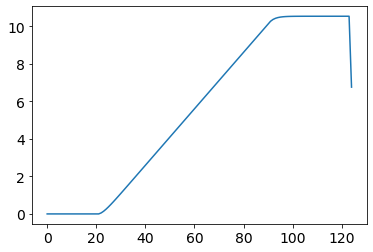

In [52]:
plt.plot(time_onepct,pulse_emulator_onepct)

In [53]:
pulse_emulator_double = emulator_pulse(time_double,double_carbon)

In [54]:
pulse_emulator_m100 = emulator_pulse(time_m100, m100_carbon)

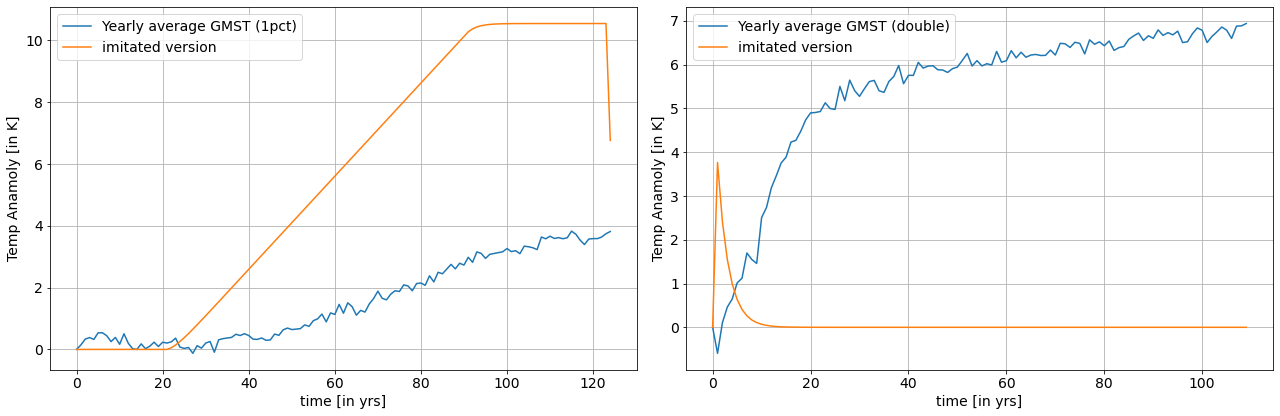

In [55]:
fig = plt.figure(figsize = (18,6))
ax1,ax2 = fig.subplots(1,2)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, pulse_emulator_onepct, label='imitated version')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='Yearly average GMST (double)')
ax2.plot(time_double, pulse_emulator_double, label='imitated version')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

plt.tight_layout()

In [56]:
onepct_emulator_m100 = emulator_onepct(time_m100,m100_carbon)
onepct_emulator_double = emulator_onepct(time_double,double_carbon)
onepct_emulator_onepct = emulator_onepct(time_onepct,onepct_carbon)

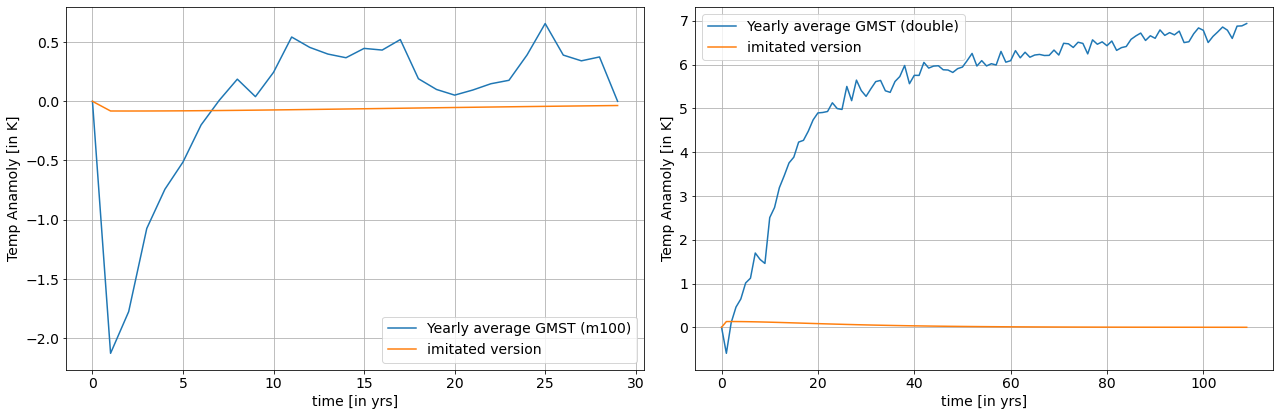

In [57]:
fig = plt.figure(figsize = (18,6))
ax1,ax2 = fig.subplots(1,2)

ax1.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='Yearly average GMST (m100)')
ax1.plot(time_m100, onepct_emulator_m100, label='imitated version')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='Yearly average GMST (double)')
ax2.plot(time_double, onepct_emulator_double, label='imitated version')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

plt.tight_layout()

In [58]:
double_emulator_m100 = emulator_double(time_m100, m100_carbon)
double_emulator_onepct = emulator_double(time_onepct, onepct_carbon)
double_emulator_double = emulator_double(time_double, double_carbon)

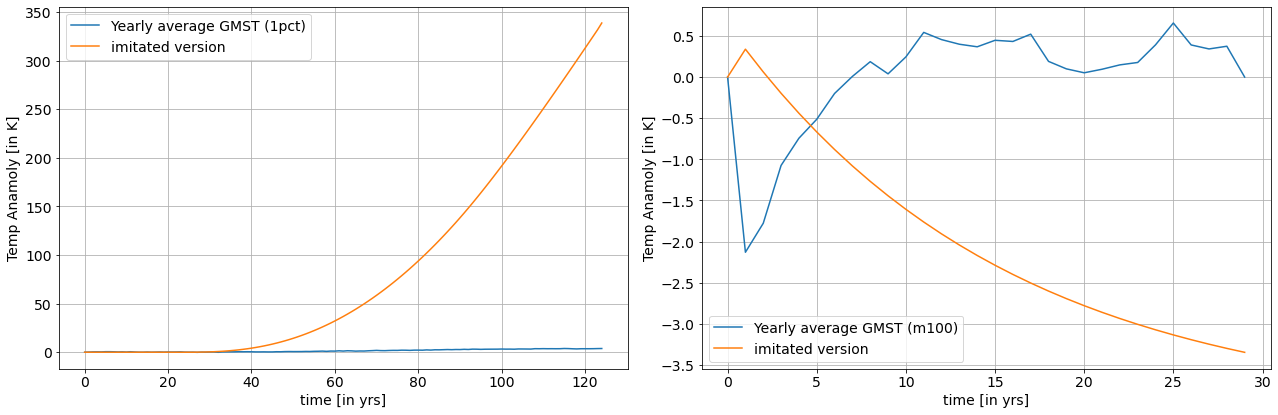

In [59]:
fig = plt.figure(figsize = (18,6))
ax1,ax2 = fig.subplots(1,2)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, double_emulator_onepct, label='imitated version')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='Yearly average GMST (m100)')
ax2.plot(time_m100, double_emulator_m100, label='imitated version')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

plt.tight_layout()

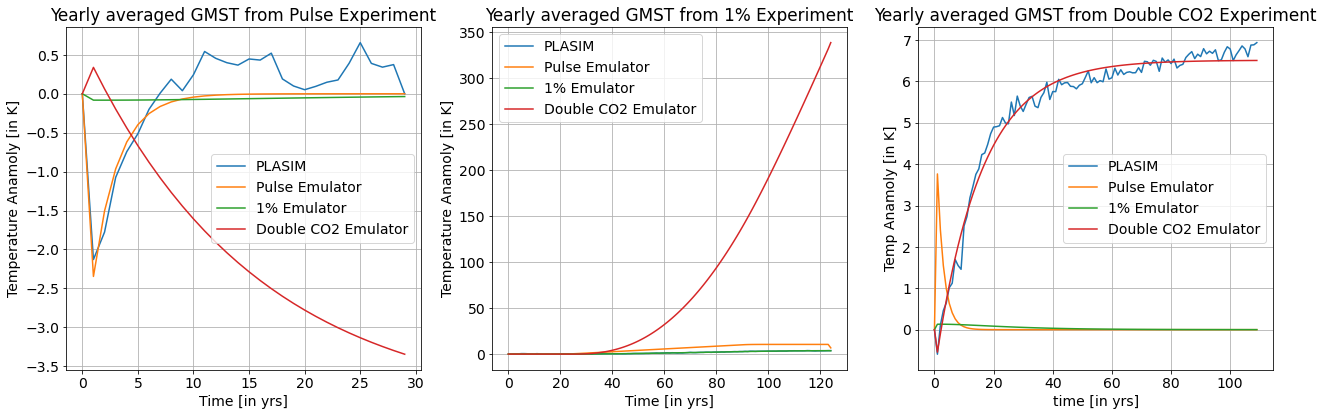

In [60]:
#everything together!

plt.rc('font', size=14)
fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='PLASIM')
ax1.plot(time_m100, pulse_emulator_m100, label='Pulse Emulator')
ax1.plot(time_m100, onepct_emulator_m100, label='1% Emulator')
ax1.plot(time_m100, double_emulator_m100, label='Double CO2 Emulator')
ax1.set_xlabel('Time [in yrs]')
ax1.set_ylabel('Temperature Anamoly [in K]')
ax1.legend()
ax1.set_title('Yearly averaged GMST from Pulse Experiment')
ax1.grid()

ax2.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='PLASIM')
ax2.plot(time_onepct, pulse_emulator_onepct, label='Pulse Emulator')
ax2.plot(time_onepct, onepct_emulator_onepct, label='1% Emulator')
ax2.plot(time_onepct, double_emulator_onepct, label='Double CO2 Emulator')
ax2.set_xlabel('Time [in yrs]')
ax2.set_ylabel('Temperature Anamoly [in K]')
ax2.legend()
ax2.set_title('Yearly averaged GMST from 1% Experiment')
ax2.grid()

ax3.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='PLASIM')
ax3.plot(time_double, pulse_emulator_double, label='Pulse Emulator')
ax3.plot(time_double, onepct_emulator_double, label='1% Emulator')
ax3.plot(time_double, double_emulator_double, label='Double CO2 Emulator')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp Anamoly [in K]')
ax3.legend()
ax3.set_title('Yearly averaged GMST from Double CO2 Experiment')
ax3.grid()

plt.tight_layout()

In [61]:
#function that calculates the sum
def m100_temp_adj(t,d1):
    d2=270
    TCR = 2.1
    ECS = 3.8
    F2x = 3.74
    q1 = 70*(TCR - ECS*(1-(d2/70)*(1-np.exp(-70/d2))))/(F2x*(d2*(1-np.exp(-70/d2))-d1*(1-np.exp(-70/d1))))
    q2 = (ECS/F2x) - q1
    #ECS = F2x*(q1+q2)
    #TCR = F2x * (q1*(1-d1/70*(1-np.exp(-70/d1))) + q2* (1-d2/70*(1-np.exp(-70/d2))))
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*m100_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    #T.append(ECS)
    #T.append(TCR)
    return T

In [62]:
GMST_m100_adj = []
for i in range(len(GMST_m100_mm)):
    GMST_m100_adj.append(GMST_m100_mm[i]- GMST_m100_mm[0])
#GMST_m100_adj.append(3.8)
#GMST_m100_adj.append(2.1)
m100_adj_fit, _ = curve_fit(m100_temp_adj, time_m100, GMST_m100_adj)

In [67]:
m100_adj_fit

array([1.53140522])

In [63]:
#the ECS seems to be close to what we want
TCR = 2.1
ECS = 3.8
F2x = 3.74
m100_ECS_adj = 3.74 * (m100_adj_fit[0] + (ECS/F2x) - m100_adj_fit[0])
m100_ECS_adj

3.8000000000000003

In [66]:
#TCR is no-where near what we want, because the d1,d2 values are wrong
d1 = m100_adj_fit[0]
d2=270
TCR = 2.1
ECS = 3.8
F2x = 3.74
q1 = 70*(TCR - ECS*(1-(d2/70)*(1-np.exp(-70/d2))))/(F2x*(d2*(1-np.exp(-70/d2))-d1*(1-np.exp(-70/d1))))
q2 = (ECS/F2x) - q1
m100_TCR_adj = F2x * (q1*(1-d1/70*(1-np.exp(-70/d1))) + q2* (1-d2/70*(1-np.exp(-70/d2))))
m100_TCR_adj

2.0999999999999996

In [68]:
def emulator_new(t,C):
    return temp(t,q1,q2,d1,d2,C)

In [69]:
new_emulator_m100 = emulator_new(time_m100, m100_carbon)
new_emulator_onepct = emulator_new(time_onepct, onepct_carbon)
new_emulator_double = emulator_new(time_double, double_carbon)

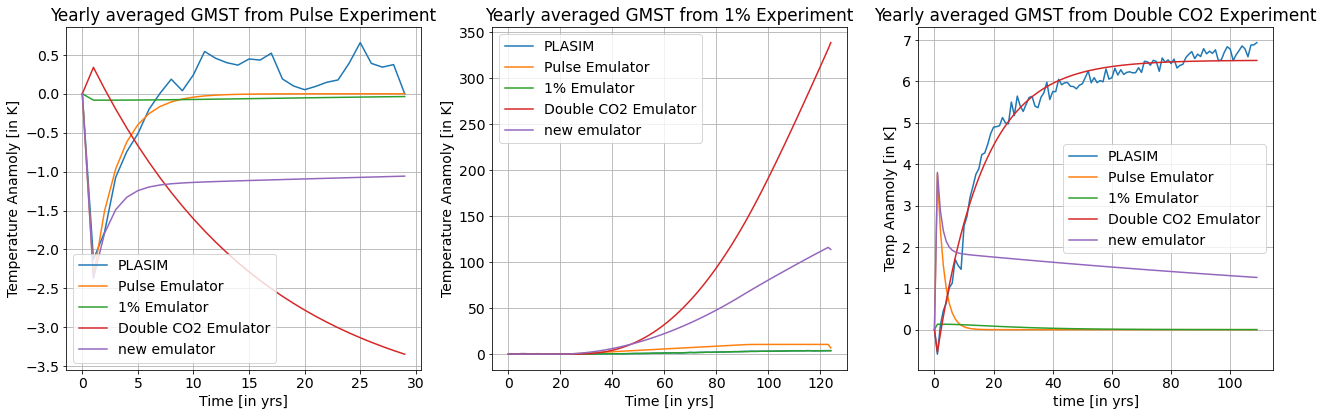

In [71]:
plt.rc('font', size=14)
fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='PLASIM')
ax1.plot(time_m100, pulse_emulator_m100, label='Pulse Emulator')
ax1.plot(time_m100, onepct_emulator_m100, label='1% Emulator')
ax1.plot(time_m100, double_emulator_m100, label='Double CO2 Emulator')
ax1.plot(time_m100, new_emulator_m100, label='new emulator')
ax1.set_xlabel('Time [in yrs]')
ax1.set_ylabel('Temperature Anamoly [in K]')
ax1.legend()
ax1.set_title('Yearly averaged GMST from Pulse Experiment')
ax1.grid()

ax2.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='PLASIM')
ax2.plot(time_onepct, pulse_emulator_onepct, label='Pulse Emulator')
ax2.plot(time_onepct, onepct_emulator_onepct, label='1% Emulator')
ax2.plot(time_onepct, double_emulator_onepct, label='Double CO2 Emulator')
ax2.plot(time_onepct, new_emulator_onepct, label='new emulator')
ax2.set_xlabel('Time [in yrs]')
ax2.set_ylabel('Temperature Anamoly [in K]')
ax2.legend()
ax2.set_title('Yearly averaged GMST from 1% Experiment')
ax2.grid()

ax3.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='PLASIM')
ax3.plot(time_double, pulse_emulator_double, label='Pulse Emulator')
ax3.plot(time_double, onepct_emulator_double, label='1% Emulator')
ax3.plot(time_double, double_emulator_double, label='Double CO2 Emulator')
ax3.plot(time_double, new_emulator_double, label='new emulator')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp Anamoly [in K]')
ax3.legend()
ax3.set_title('Yearly averaged GMST from Double CO2 Experiment')
ax3.grid()

plt.tight_layout()

In [74]:
def m100_temp_adj2(t,d1,d2):
    #d2=270
    TCR = 2.1
    ECS = 3.8
    F2x = 3.74
    q1 = 70*(TCR - ECS*(1-(d2/70)*(1-np.exp(-70/d2))))/(F2x*(d2*(1-np.exp(-70/d2))-d1*(1-np.exp(-70/d1))))
    q2 = (ECS/F2x) - q1
    #ECS = F2x*(q1+q2)
    #TCR = F2x * (q1*(1-d1/70*(1-np.exp(-70/d1))) + q2* (1-d2/70*(1-np.exp(-70/d2))))
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*m100_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    #T.append(ECS)
    #T.append(TCR)
    return T

In [75]:
m100_adj2_fit, _ = curve_fit(m100_temp_adj2, time_m100, GMST_m100_mm)
m100_adj2_fit

C:\Users\annik\AppData\Local\Temp/ipykernel_17220/3992791021.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  q1 = 70*(TCR - ECS*(1-(d2/70)*(1-np.exp(-70/d2))))/(F2x*(d2*(1-np.exp(-70/d2))-d1*(1-np.exp(-70/d1))))
C:\Users\annik\AppData\Local\Temp/ipykernel_17220/3992791021.py:20: RuntimeWarning: invalid value encountered in double_scalars
  R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [ ]:
# I'm a little out of ideas what else to try in order to get a better emulator. I thought of 
# simultaniously fitting the emulator to the 1% and doubling experiments. But I don't know how to 
# implement that... 

# I also don't get the RCP scenarios and how to apply our emulator to them...